In [35]:
import geopandas as gpd
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [36]:
def peek(df):
    display(df.head())
    display(len(df))

In [37]:
cbg_df = pd.read_csv('./data/cbg_attr_and_cluster_1021.csv')
cbg_df = cbg_df.rename(columns={
    'census_block_group': 'cbg',
    'Cluster': 'cluster',
    'Total Population': 'population',
    # Demographics.
    'Median Age': 'age',
    # Socioeconomics.
    'Median Household Income': 'income',
    'Percent Employed': 'employed_pct',
    'Percent Households with one or more people under 18 years': 'children_pct',
    'Percent Households with one or more people 60 years and over': 'seniors_pct',
    'Percent Household received Food Stamps/SNAP': 'snap_pct',
    'Percent Households Income in the past 12 months below poverty level': 'poverty_pct',
    'Percent over 25 with a bachelor’s degree or higher': 'college_pct',
    'Percent over 25 without a high school diploma': 'no_hs_pct',
})
cbg_df = cbg_df[[
    'cbg',
    'population',
    'income',
    'age',
    'employed_pct',
    'children_pct',
    'seniors_pct',
    'snap_pct',
    'poverty_pct',
    'college_pct',
    'no_hs_pct',
]]
# XXX
cbg_df = cbg_df.fillna(0)
peek(cbg_df)

,cbg,population,income,age,employed_pct,children_pct,seniors_pct,snap_pct,poverty_pct,college_pct,no_hs_pct
0,360050001001,6864,0.0,35.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.014873,0.515975
1,360050002001,1744,41968.0,40.2,0.762500,0.423913,0.541304,0.334783,0.326087,0.277975,0.246892
2,360050002002,1569,48523.0,28.9,0.860104,0.421384,0.425577,0.190776,0.144654,0.303395,0.243154
3,360050002003,1219,68060.0,42.2,0.985940,0.407407,0.585185,0.108642,0.024691,0.306054,0.137892
4,360050004001,598,0.0,40.3,1.000000,0.213740,0.492366,0.095420,0.312977,0.206989,0.174731


6221

In [38]:
pi_df = pd.read_csv('./exports/proximity_index_sampled.csv')
# Drop the community food category.
pi_df = pi_df.drop(columns=['category_0_proximity_index'])
peek(pi_df)

,cbg,category_1_proximity_index,category_2_proximity_index,category_3_proximity_index,category_4_proximity_index,category_5_proximity_index
0,360050175002,3.797873e+07,1.700004e+06,7.140570e+07,9.457042e+06,0.0
1,360050141001,2.519102e+07,0.000000e+00,8.055972e+07,7.236315e+06,0.0
2,360050145001,7.691838e+06,2.430318e+06,1.680503e+06,1.284172e+07,0.0
3,360050075002,5.906373e+06,9.508684e+06,9.073975e+06,4.938371e+06,0.0
4,360050418001,2.902821e+06,6.403403e+05,7.202926e+05,1.438321e+06,0.0


6221

In [39]:
cbg_df = cbg_df.merge(pi_df, on='cbg', how='inner')
cbg_df.index = cbg_df['cbg']
cbg_df = cbg_df.drop(columns=['cbg'])
peek(cbg_df)

,population,income,age,employed_pct,children_pct,seniors_pct,snap_pct,poverty_pct,college_pct,no_hs_pct,category_1_proximity_index,category_2_proximity_index,category_3_proximity_index,category_4_proximity_index,category_5_proximity_index
cbg,,,,,,,,,,,,,,,
360050001001,6864,0.0,35.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.014873,0.515975,0.0,0.0,0.000000,0.0,0.0
360050002001,1744,41968.0,40.2,0.762500,0.423913,0.541304,0.334783,0.326087,0.277975,0.246892,0.0,0.0,956978.984138,0.0,0.0
360050002002,1569,48523.0,28.9,0.860104,0.421384,0.425577,0.190776,0.144654,0.303395,0.243154,0.0,0.0,476694.693371,0.0,0.0
360050002003,1219,68060.0,42.2,0.985940,0.407407,0.585185,0.108642,0.024691,0.306054,0.137892,0.0,0.0,0.000000,0.0,0.0
360050004001,598,0.0,40.3,1.000000,0.213740,0.492366,0.095420,0.312977,0.206989,0.174731,0.0,0.0,558255.672315,0.0,0.0


6221

In [40]:
# Credit: Maia Guo
np.random.seed(0)
cbg_std_df = cbg_df
scalers = []
for column in cbg_df.columns:
    scaler = StandardScaler()
    cbg_std_df[column] = scaler.fit_transform(cbg_df[[column]])
    scalers.append(scaler)
peek(cbg_std_df)

,population,income,age,employed_pct,children_pct,seniors_pct,snap_pct,poverty_pct,college_pct,no_hs_pct,category_1_proximity_index,category_2_proximity_index,category_3_proximity_index,category_4_proximity_index,category_5_proximity_index
cbg,,,,,,,,,,,,,,,
360050001001,8.362575,-1.547118,-0.391198,-12.493857,-2.035888,-2.458672,-1.070524,-1.210429,-1.500838,2.488989,-0.591789,-0.191138,-0.407117,-0.448014,-0.382859
360050002001,0.592800,-0.614118,0.206562,-2.284310,0.806662,0.963631,0.758879,1.035222,-0.398696,0.503632,-0.591789,-0.191138,-0.393026,-0.448014,-0.382859
360050002002,0.327231,-0.468393,-1.092416,-0.977439,0.789701,0.231962,-0.028040,-0.214245,-0.292210,0.476058,-0.591789,-0.191138,-0.400098,-0.448014,-0.382859
360050002003,-0.203906,-0.034061,0.436470,0.707459,0.695983,1.241060,-0.476855,-1.040388,-0.281073,-0.300589,-0.591789,-0.191138,-0.407117,-0.448014,-0.382859
360050004001,-1.146294,-1.547118,0.218057,0.895713,-0.602651,0.654229,-0.549107,0.944939,-0.696058,-0.028784,-0.591789,-0.191138,-0.398897,-0.448014,-0.382859


6221

In [41]:
# Credit: Maia Guo
np.random.seed(0)
pca = PCA()
cbg_pca_df = pca.fit_transform(cbg_std_df)
eigenvalues = pca.explained_variance_ratio_

In [42]:
eigenvalues

array([0.27645043, 0.14593655, 0.11027164, 0.06921425, 0.06555676,
       0.05695721, 0.04770454, 0.04572821, 0.04406145, 0.03407388,
       0.03141464, 0.02717053, 0.0181533 , 0.01467219, 0.01263441])

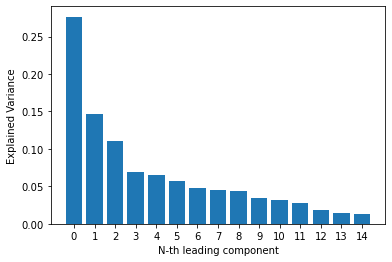

In [43]:
# Credit: Maia Guo
plt.bar(np.arange(len(eigenvalues)).astype(str), eigenvalues) 
plt.xlabel("N-th leading component")
plt.ylabel("Explained Variance")
plt.show()

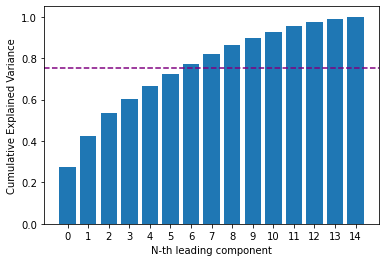

In [44]:
# Credit: Maia Guo
N = len(eigenvalues)
stack_e = [np.sum(eigenvalues[:i]) for i in range(1, N + 1)]
np.array(stack_e).reshape(N,)
plt.bar(np.arange(N).astype(str), stack_e) 
plt.axhline(y=0.75, color='purple', linestyle='--')
plt.xlabel("N-th leading component")
plt.ylabel("Cumulative Explained Variance")
plt.show()

In [45]:
N_PC = 7
K = 4
np.random.seed(0)
km = KMeans(n_clusters=K).fit(cbg_pca_df[:, :N_PC])
cbg_km_df = cbg_std_df
cbg_km_df['cluster'] = km.predict(cbg_pca_df[:, :N_PC])
peek(cbg_km_df)

,population,income,age,employed_pct,children_pct,seniors_pct,snap_pct,poverty_pct,college_pct,no_hs_pct,category_1_proximity_index,category_2_proximity_index,category_3_proximity_index,category_4_proximity_index,category_5_proximity_index,cluster
cbg,,,,,,,,,,,,,,,,
360050001001,8.362575,-1.547118,-0.391198,-12.493857,-2.035888,-2.458672,-1.070524,-1.210429,-1.500838,2.488989,-0.591789,-0.191138,-0.407117,-0.448014,-0.382859,3
360050002001,0.592800,-0.614118,0.206562,-2.284310,0.806662,0.963631,0.758879,1.035222,-0.398696,0.503632,-0.591789,-0.191138,-0.393026,-0.448014,-0.382859,3
360050002002,0.327231,-0.468393,-1.092416,-0.977439,0.789701,0.231962,-0.028040,-0.214245,-0.292210,0.476058,-0.591789,-0.191138,-0.400098,-0.448014,-0.382859,2
360050002003,-0.203906,-0.034061,0.436470,0.707459,0.695983,1.241060,-0.476855,-1.040388,-0.281073,-0.300589,-0.591789,-0.191138,-0.407117,-0.448014,-0.382859,1
360050004001,-1.146294,-1.547118,0.218057,0.895713,-0.602651,0.654229,-0.549107,0.944939,-0.696058,-0.028784,-0.591789,-0.191138,-0.398897,-0.448014,-0.382859,1


6221

In [46]:
cbg_gdf = gpd.read_file('./data/nyc_cbgs.geojson')
cbg_gdf = cbg_gdf.rename(columns={
    'CensusBlockGroup': 'cbg',
})
cbg_gdf['cbg'] = cbg_gdf['cbg'].astype(int)
cbg_gdf = cbg_gdf[['cbg', 'geometry']]
peek(cbg_gdf)

,cbg,geometry
0,360050175002,"MULTIPOLYGON (((-73.91570 40.83054, -73.91485 ..."
1,360050141001,"MULTIPOLYGON (((-73.91661 40.82499, -73.91592 ..."
2,360050145001,"MULTIPOLYGON (((-73.90584 40.83106, -73.90505 ..."
3,360050075002,"MULTIPOLYGON (((-73.91035 40.81995, -73.91022 ..."
4,360050418001,"MULTIPOLYGON (((-73.86288 40.89515, -73.86146 ..."


6493

In [47]:
cbg_km_gdf = cbg_gdf.merge(cbg_km_df, on='cbg', how='inner')
cbg_km_gdf['color'] = 'C' + cbg_km_gdf['cluster'].astype(str)
peek(cbg_km_gdf)

,cbg,geometry,population,income,age,employed_pct,children_pct,seniors_pct,snap_pct,poverty_pct,college_pct,no_hs_pct,category_1_proximity_index,category_2_proximity_index,category_3_proximity_index,category_4_proximity_index,category_5_proximity_index,cluster,color
0,360050175002,"MULTIPOLYGON (((-73.91570 40.83054, -73.91485 ...",-1.058277,-1.011546,2.114796,0.895713,-1.455244,1.885720,2.195936,1.963591,-1.563143,3.287423,3.348583,-0.112815,0.644289,0.119877,-0.382859,3,C3
1,360050141001,"MULTIPOLYGON (((-73.91661 40.82499, -73.91592 ...",-0.190248,-1.136463,-0.782041,-0.051662,0.510336,-0.359609,2.090819,2.855850,-1.135108,1.617216,2.021832,-0.191138,0.779077,-0.013477,-0.382859,3,C3
2,360050145001,"MULTIPOLYGON (((-73.90584 40.83106, -73.90505 ...",2.067843,-0.710602,-1.057930,-0.966054,1.323762,-0.526850,1.931551,1.233911,-1.359043,1.058122,0.206255,-0.079167,-0.382372,0.323125,-0.382859,3,C3
3,360050075002,"MULTIPOLYGON (((-73.91035 40.81995, -73.91022 ...",3.239380,-0.834897,-0.816527,-1.181979,0.537941,-0.500241,1.091338,0.638767,-0.600433,0.151077,0.021009,0.246951,-0.273508,-0.151467,-0.382859,3,C3
4,360050418001,"MULTIPOLYGON (((-73.86288 40.89515, -73.86146 ...",-1.056760,-0.014654,0.424974,-0.984845,0.034474,-1.205861,1.120293,-0.893071,-0.065706,-0.049336,-0.290615,-0.161636,-0.396511,-0.361643,-0.382859,2,C2


6221

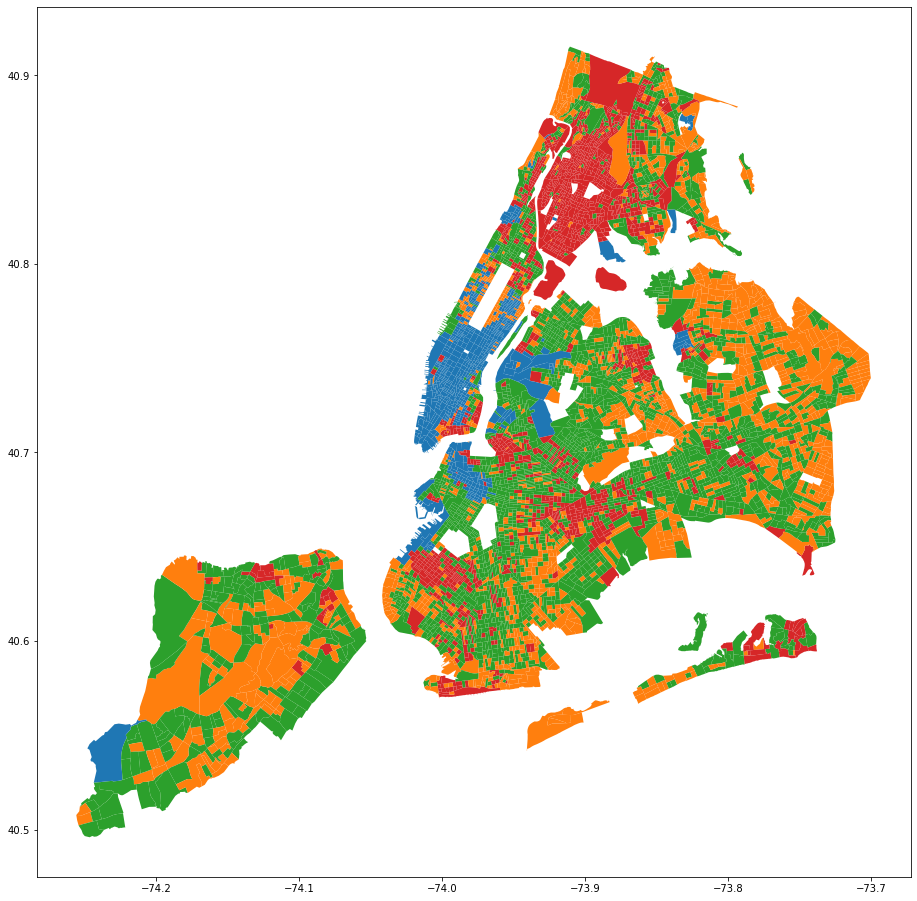

In [48]:
fig, ax = plt.subplots(figsize=(16, 16))
cbg_km_gdf.plot(ax=ax, column='cluster', color=cbg_km_gdf['color'])
plt.show()

In [49]:
cdi_2020_df = pd.read_csv('./exports/cdi/cbg_diff_2020.csv')
cdi_2020_df = cdi_2020_df.rename(columns={'cdi': 'cdi_diff'})
cbg_km_df = cbg_km_df.merge(cdi_2020_df, on='cbg', how='inner')
peek(cbg_km_df)

,cbg,population,income,age,employed_pct,children_pct,seniors_pct,snap_pct,poverty_pct,college_pct,no_hs_pct,category_1_proximity_index,category_2_proximity_index,category_3_proximity_index,category_4_proximity_index,category_5_proximity_index,cluster,cdi_diff
0,360050001001,8.362575,-1.547118,-0.391198,-12.493857,-2.035888,-2.458672,-1.070524,-1.210429,-1.500838,2.488989,-0.591789,-0.191138,-0.407117,-0.448014,-0.382859,3,4.211850
1,360050002001,0.592800,-0.614118,0.206562,-2.284310,0.806662,0.963631,0.758879,1.035222,-0.398696,0.503632,-0.591789,-0.191138,-0.393026,-0.448014,-0.382859,3,0.273660
2,360050002002,0.327231,-0.468393,-1.092416,-0.977439,0.789701,0.231962,-0.028040,-0.214245,-0.292210,0.476058,-0.591789,-0.191138,-0.400098,-0.448014,-0.382859,2,0.122550
3,360050002003,-0.203906,-0.034061,0.436470,0.707459,0.695983,1.241060,-0.476855,-1.040388,-0.281073,-0.300589,-0.591789,-0.191138,-0.407117,-0.448014,-0.382859,1,0.100032
4,360050004001,-1.146294,-1.547118,0.218057,0.895713,-0.602651,0.654229,-0.549107,0.944939,-0.696058,-0.028784,-0.591789,-0.191138,-0.398897,-0.448014,-0.382859,1,0.092628


6216

In [50]:
cbg_km_df['cdi_diff_per_capita'] = cbg_km_df['cdi_diff'] / cbg_km_df['population']

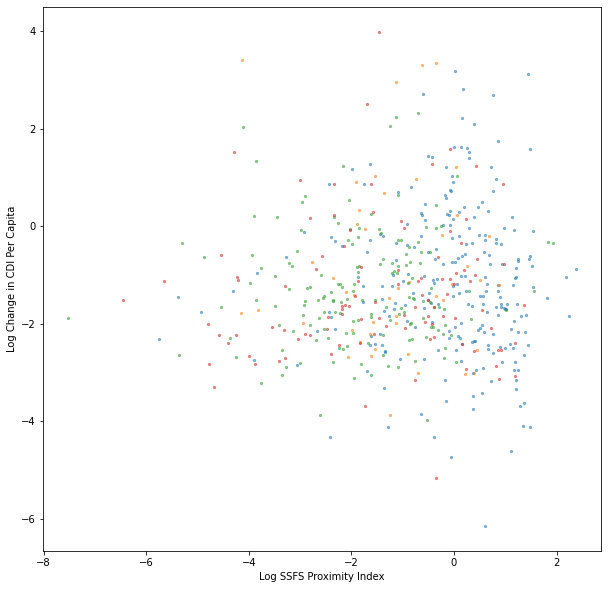

In [51]:
fig, ax = plt.subplots(figsize=(10, 10))
for i in range(0, K):
    df = cbg_km_df[cbg_km_df['cluster'] == i]
    x = np.log(df['category_5_proximity_index'])
    y = np.log(df['cdi_diff_per_capita'])
    ax.scatter(x, y, c=f'C{i}', alpha=0.5, s=5)
ax.set_xlabel('Log SSFS Proximity Index')
ax.set_ylabel('Log Change in CDI Per Capita')
plt.show()

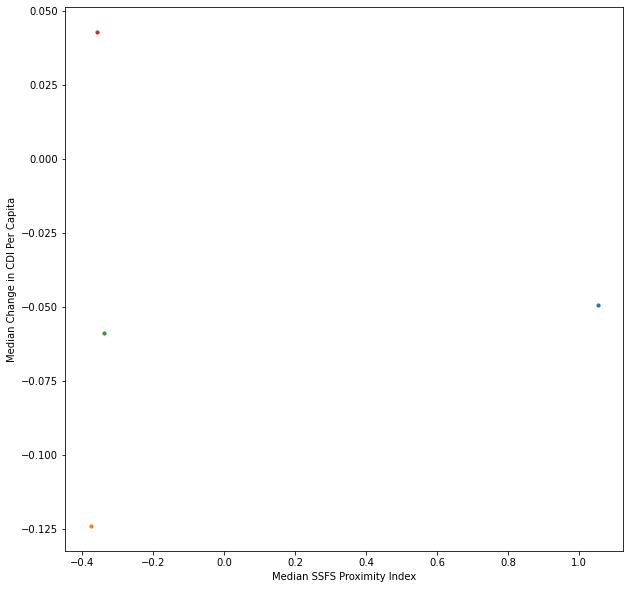

In [52]:
fig, ax = plt.subplots(figsize=(10, 10))
for i in range(0, K):
    df = cbg_km_df[cbg_km_df['cluster'] == i]
    x = np.median(df['category_5_proximity_index'])
    y = np.median(df['cdi_diff_per_capita'])
    ax.scatter(x, y, c=f'C{i}', s=10)
ax.set_xlabel('Median SSFS Proximity Index')
ax.set_ylabel('Median Change in CDI Per Capita')
plt.show()

In [59]:
cbg_csv_df = cbg_km_df
for i, column in enumerate(cbg_csv_df.columns[1:len(scalers)+1]):
    print(i, column)
    cbg_csv_df[column] = scalers[i].inverse_transform(cbg_csv_df[column])
peek(cbg_csv_df)

0 population
1 income
2 age
3 employed_pct
4 children_pct
5 seniors_pct
6 snap_pct
7 poverty_pct
8 college_pct
9 no_hs_pct
10 category_1_proximity_index
11 category_2_proximity_index
12 category_3_proximity_index
13 category_4_proximity_index
14 category_5_proximity_index


,cbg,population,income,age,employed_pct,children_pct,seniors_pct,snap_pct,poverty_pct,college_pct,no_hs_pct,category_1_proximity_index,category_2_proximity_index,category_3_proximity_index,category_4_proximity_index,category_5_proximity_index,cluster,cdi_diff,cdi_diff_per_capita
0,360050001001,6864.0,0.0,35.0,1.110223e-16,0.000000,0.000000,0.000000,0.000000,0.014873,0.515975,9.313226e-10,0.0,0.000000,0.0,0.0,3,4.211850,0.503655
1,360050002001,1744.0,41968.0,40.2,7.625000e-01,0.423913,0.541304,0.334783,0.326087,0.277975,0.246892,9.313226e-10,0.0,956978.984138,0.0,0.0,3,0.273660,0.461639
2,360050002002,1569.0,48523.0,28.9,8.601036e-01,0.421384,0.425577,0.190776,0.144654,0.303395,0.243154,9.313226e-10,0.0,476694.693371,0.0,0.0,2,0.122550,0.374505
3,360050002003,1219.0,68060.0,42.2,9.859402e-01,0.407407,0.585185,0.108642,0.024691,0.306054,0.137892,9.313226e-10,0.0,0.000000,0.0,0.0,1,0.100032,-0.490582
4,360050004001,598.0,0.0,40.3,1.000000e+00,0.213740,0.492366,0.095420,0.312977,0.206989,0.174731,9.313226e-10,0.0,558255.672315,0.0,0.0,1,0.092628,-0.080807


6216

In [60]:
cbg_csv_df.to_csv('./exports/proximity_clusters.csv', index=False)